###  This is a template for the get_date monte carlo function. 

In [1]:
import rasterio as rio
import numpy as np
from numpy.random import choice

# for plotting comparisons
import matplotlib.pyplot as plt
from rasterio.plot import show

In [2]:
# input spill month
spill_month = 9;
# input desired number of latitude and longitude values (we will likely keep this as one, but I add here just in case)
n_locations = 1;  
# static variables
geotiff_directory = '/Users/rmueller/Data/MIDOSS/'


In [3]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [4]:
def get_lat_lon(geotiff_directory, spill_month, n_locations):
    
    # identify string to use for input file name
    if spill_month==9:
        month_name = 'September' #I'm sure there is a way to do this using Datetime!
    
    # load data
    traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')
    traffic_data = traffic_reader.read(1)
    traffic_data[traffic_data < 0] = 0

    # calculate probability of traffic by VTE in given month
    probability_distribution  = traffic_data/traffic_data.sum()
    [nx,ny] = probability_distribution.shape

    # create a matrix of lat/lon values 
    latlontxt = np.chararray((nx,ny), itemsize = 25)
    for y in range(ny):
        for x in range(nx):
            x2, y2 = traffic_reader.transform * (y,x)
            latlontxt[x,y] = "lat" + str(truncate(x2, 5)) + "lon" + str(truncate(y2, 5))

    # reshape 2D matrix to vector
    latlontxt_1D = latlontxt.reshape(-1)

    print(latlontxt_1D[0])
    
    # use 'choice' function to randomly select lat/lon location based on vessel time exposure probability
    a = choice(latlontxt.reshape(-1), n_locations , p=probability_distribution.reshape(-1))

    # extract lat/lon value(s)
    lats = np.array([])
    lons = np.array([])
    for i in a:
        lats = np.append(lats, float(i[3:12]))
        lons = np.append(lons, float(i[16:]))
        
    return lats, lons, traffic_reader

In [5]:
(lat,lon, traffic_reader) = get_lat_lon(geotiff_directory, spill_month, n_locations)

b'lat-128.66497lon51.02318'


### Verify methodology

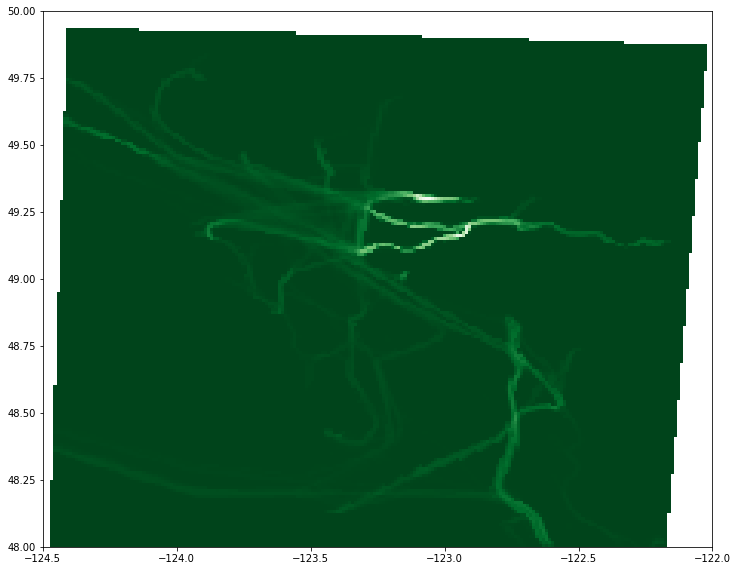

In [6]:
fig, ax = plt.subplots(figsize = (12,12))
show(traffic_reader, ax=ax, cmap = "Greens_r")
ax.set_xlim(-124.5, -122)
ax.set_ylim(48, 50);

In [7]:
(lat,lon, traffic_reader) = get_lat_lon(geotiff_directory, spill_month, 10000)

b'lat-128.66497lon51.02318'


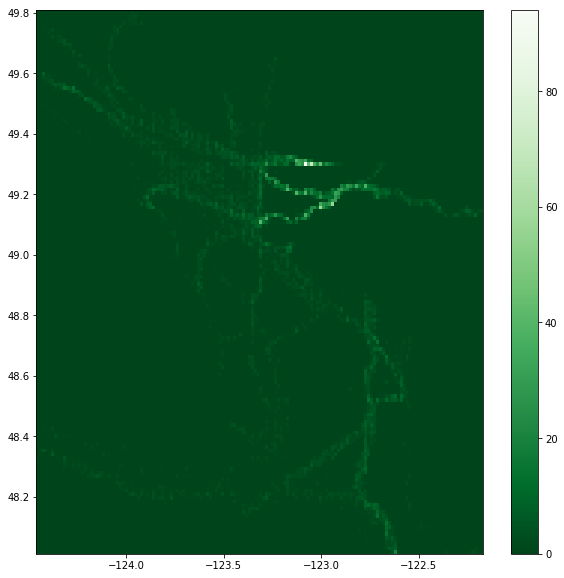

In [8]:
fig, ax = plt.subplots(figsize = (10,10))

h = ax.hist2d(lat, lon, bins=150, cmap = "Greens_r");
plt.colorbar(h[3], ax=ax)

### Investigate upsampling
We want to resolve smaller scales then the 1 km x 1 km geotiff grid spacing. We also want to identify the (x,y) index pair corresponding to the chosen location.  The following code refines the above example to both upsample the geotiff and return the (x,y) geotiff index to use to extract values from vessel-type geotiffs

In [71]:
from rasterio.enums import Resampling
upsample_factor = 4

# identify string to use for input file name
if spill_month==9:
    month_name = 'September' #I'm sure there is a way to do this using Datetime!
    
traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')

with traffic_reader as dataset:

    # resample data to target shape
    data = dataset.read(1,
        out_shape=(
            dataset.count,
            int(dataset.height * upsample_factor),
            int(dataset.width * upsample_factor)
        ),
        resampling=Resampling.bilinear
    )

    print(dataset.scales)
    
    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

(1.0,)


In [10]:
# data 
data = np.squeeze(data)
data[data<0]=0

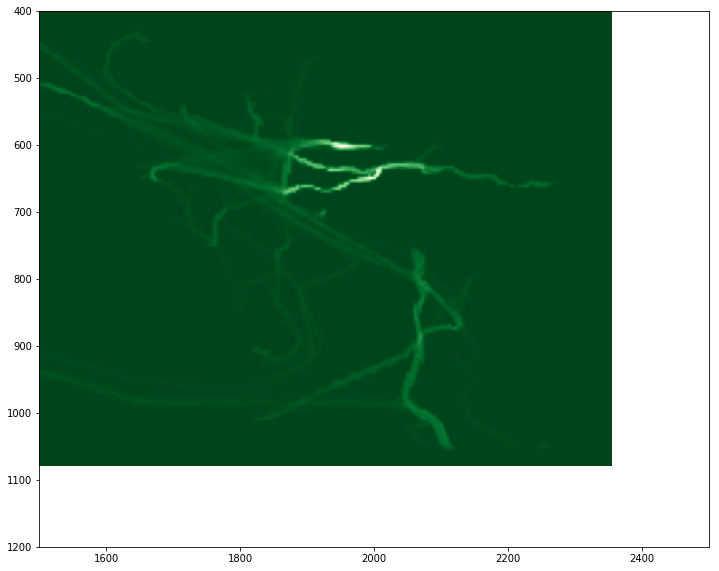

In [11]:
fig, ax = plt.subplots(figsize = (12,12))
h = show(data, ax=ax, cmap = "Greens_r")
ax.set_xlim(1500, 2500)
ax.set_ylim(1200, 400);

In [64]:
transform

Affine(0.0028637723267861477, 0.0, -128.6649765716981,
       0.0, -0.002863772326786147, 51.02318999694867)

In [12]:
# calculate upsampled probability of traffic by VTE in given month
probability_distribution  = data/data.sum()
[nx,ny] = probability_distribution.shape

# create a matrix of lat/lon values 
latlontxt = np.chararray((nx,ny), itemsize = 25)
for y in range(ny):
    for x in range(nx):
        x2, y2 = traffic_reader.transform * (y,x)
        latlontxt[x,y] = "lat" + str(truncate(x2, 5)) + "lon" + str(truncate(y2, 5))

In [13]:
# use 'choice' function to randomly select lat/lon location based on vessel time exposure probability
z = choice(latlontxt.reshape(-1), 1 , p=probability_distribution.reshape(-1))

In [31]:
i, j = np.where(latlontxt == z)

#### Confussion alert!  Note below how the array indexing is opposit the geotiff reader indexing

In [37]:
z

array([b'lat-107.58761lon43.42846'],
      dtype='|S25')

In [36]:
latlontxt[i,j]

chararray([b'lat-107.58761lon43.42846'],
          dtype='|S25')

In [39]:
traffic_reader.transform * (j,i)

(array([-107.58761225]), array([ 43.42846579]))

In [41]:
probability_distribution.shape

(1080, 2356)

#### compare values to make sure that indexing is correct

In [46]:
traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')
traffic_data = traffic_reader.read(1)
traffic_data[traffic_data < 0] = 0
probability_distribution_sm  = traffic_data/traffic_data.sum()
probability_distribution_sm.shape

(270, 589)

In [67]:
print(i,j)
print(probability_distribution[i,j])
print(np.round(i/upsample_factor), np.int(np.round(j/upsample_factor)))
print(probability_distribution_sm[np.int(np.round(i/upsample_factor)), 
                                  np.int(np.round(j/upsample_factor))])


[663] [1840]
[  2.53431408e-05]
[ 166.] 460
0.000466062


#### These values are way off!  WHY?

In [63]:
print(f'upsampled VTE sum: {data.sum()}')
print(f'original VTE sum: {traffic_data.sum()}')

upsampled VTE sum: 54655244.0
original VTE sum: 3413033.25


In [65]:
54655244.0/3413033.25

16.01368635948683

####  Ah... upsampling by a factor of 4 changes the net sum of all VTE values by a factor of 4^2.  If this is true then the values ought to be different by the same factor

In [68]:
print(54655244.0*probability_distribution[i,j]/3413033.25)

[ 0.00040584]


In [69]:
# close by no cigar.  Try floor instaed of round
print(probability_distribution_sm[np.int(np.floor(i/upsample_factor)), 
                                  np.int(np.floor(j/upsample_factor))])

0.000390321


In [ ]:
# I can live with this difference.  

In [70]:
traffic_reader.scales

(1.0,)

In [84]:
print(data[i,j])
print(traffic_data[np.int(np.floor(i/upsample_factor)), 
                   np.int(np.floor(j/upsample_factor))])

[ 1385.13549805]
1332.18


### combine the above to create a function that returns lat, lon and index values for extracting VTE from multiple geotiff files

In [111]:
from rasterio.enums import Resampling
upsample_factor = 4

def get_lat_lon_indices(geotiff_directory, spill_month, n_locations, upsample_factor):    

    print('Randomly selecting spill location from all-traffic GeoTIFF:')
    # identify string to use for input file name
    if spill_month==9:
        month_name = 'September' #I'm sure there is a way to do this using Datetime!

    traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')

    # dataset closes automatically using the method below
    with traffic_reader as dataset:

        # resample data to target shape
        data = dataset.read(1,
            out_shape=(
                dataset.count,
                int(dataset.height * upsample_factor),
                int(dataset.width * upsample_factor)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )
        
    # remove no-data values and singular dimension 
    data = np.squeeze(data)
    data[data < 0] = 0
    
    # calculate upsampled probability of traffic by VTE in given month
    probability_distribution  = data/data.sum()
    [nx,ny] = probability_distribution.shape

    # create a matrix of lat/lon values 
    print('...Creating 2D array of lat/lon strings (this may take a moment)')
    latlontxt = np.chararray((nx,ny), itemsize = 25)
    for y in range(ny):
        for x in range(nx):
            x2, y2 = traffic_reader.transform * (y,x)
            latlontxt[x,y] = "lat" + str(truncate(x2, 5)) + "lon" + str(truncate(y2, 5))

    # reshape 2D matrix to vector
    latlontxt_1D = latlontxt.reshape(-1)
  
    # use 'choice' function to randomly select lat/lon locations
    print(f'...Selecting {n_locations} location(s)')
    latlontxt_random = choice(latlontxt.reshape(-1), 
                              n_locations , 
                              p = probability_distribution.reshape(-1))

    # extract lat/lon value(s)
    lats = np.array([])
    lons = np.array([])
    x_index = np.array([], dtype = np.int)
    y_index = np.array([], dtype = np.int)
    data_out= np.array([])
    
    print('...Creating vectors of lat/lon pairs and x-index/y-index pairs')
    for latlontxt_str in latlontxt_random:
        
        # create lat/lon vectors
        lats = np.append(lats, float(latlontxt_str[3:12]))
        lons = np.append(lons, float(latlontxt_str[16:]))    
        
        # find x-, y-indices of selected lat/lon pair in 2D latlontxt array
        another_x, another_y = np.where(latlontxt == latlontxt_str)
        
        # create indice vectors
        x_index = np.append(
            x_index, 
            np.int( np.floor(another_x) / upsample_factor) 
        )
        y_index = np.append(
            y_index, 
            np.int(np.floor(another_y) /upsample_factor)
        )
         
        # create data array at x-index, y-index location for QAQC/comparison
        data_out = np.append(
            data_out,
            data[another_x, another_y]
        )
        print("That's a wrap, folks!")
    
    return lats, lons, x_index, y_index, data_out

In [119]:
# okay...here goes nothing!  A test drive...

[lats, lons, x_index, y_index, data_val] = get_lat_lon_indices(geotiff_directory, spill_month, 1, 4)    



Randomly selecting spill location from all-traffic GeoTIFF:
...Creating 2D array of lat/lon strings (this may take a moment)
...Selecting 1 location(s)
...Creating vectors of lat/lon pairs and x-index/y-index pairs
That's a wrap, folks!


In [120]:
x_index[0]

238

In [121]:
y_index[0]

489

##### compare output data_val with direct read of geotiff data for QAQC

In [122]:
traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')
traffic_data = traffic_reader.read(1)
traffic_data[traffic_data < 0] = 0

In [123]:
traffic_data.shape

(270, 589)

In [124]:
traffic_data[x_index[0],y_index[0]]

671.15704

In [125]:
data_val[0]

726.9881591796875

##### Now test case of 1-1 scaling (no up-sampling)
We expect small differences in the above because data-val is an interpolated value; but the 1-1 mapping below ought to produce the same result

In [126]:
[lats, lons, x_index, y_index, data_val] = get_lat_lon_indices(geotiff_directory, spill_month, 1, 1)    

Randomly selecting spill location from all-traffic GeoTIFF:
...Creating 2D array of lat/lon strings (this may take a moment)
...Selecting 1 location(s)
...Creating vectors of lat/lon pairs and x-index/y-index pairs
That's a wrap, folks!


In [127]:
traffic_data[x_index[0],y_index[0]]

383.03043

In [128]:
data_val[0]

383.03042602539062

##### Bingo pajamas!  1-1 :-)   

### BELOW: Experimental dev stuff
#####  Let's make sure that we can convert these indices to the non-upsampled geotiffs

In [ ]:
# extract lat/lon value(s)
lats = np.array([])
lons = np.array([])
for location_string in z:
    lats = np.append(lats, float(location_string[3:12]))
    lons = np.append(lons, float(location_string[16:]))

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

h = ax.hist2d(lat, lon, bins = 150, cmap = "Greens_r");
plt.colorbar(h[3], ax=ax)

In [ ]:
# subsample spacing of 1 km grid (e.g. subsample = 0.1 -> 100 m)
subsample = 0.5

# identify string to use for input file name
if spill_month==9:
    month_name = 'September' #I'm sure there is a way to do this using Datetime!
    
# load data
traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')
traffic_data = traffic_reader.read(1)
traffic_data[traffic_data < 0] = 0

# calculate probability of traffic by VTE in given month
probability_distribution  = traffic_data/traffic_data.sum()
[nx,ny] = probability_distribution.shape

# create a matrix of lat/lon values 
y_list = np.arange(0,ny,subsample)
x_list = np.arange(0,nx,subsample)
latlontxt = np.chararray((len(x_list),len(y_list)), itemsize = 25)
x_ind = 0
y_ind = 0
for y in range(len(y_list)):
    x_ind = 0
    for x in range(len(x_list)):
        x2, y2 = traffic_reader.transform * (y,x)
        latlontxt[x_ind,y_ind] = "lat" + str(truncate(x2, 5)) + "lon" + str(truncate(y2, 5))
        x_ind += 1
    y_ind += 1


In [ ]:
traffic_reader.shape

In [ ]:
# print out 4-corners and test use of "transpose"
print('4 corners:')
print(traffic_reader.transform * (0,0))
print(traffic_reader.transform * (0,270))
print(traffic_reader.transform * (589,270))
print(traffic_reader.transform * (589,0))

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
show(traffic_reader, ax=ax, cmap = "Greens_r")
#ax.set_xlim(-124.5, -122)
#ax.set_ylim(48, 50);

In [ ]:
latlontxt.shape

In [ ]:
 # reshape 2D matrix to vector
latlontxt_1D = latlontxt.reshape(-1)

print(latlontxt_1D[0])
    
# use 'choice' function to randomly select lat/lon location based on vessel time exposure probability
z = choice(latlontxt.reshape(-1), n_locations , p=probability_distribution.reshape(-1))



In [ ]:
    # extract lat/lon value(s)
    lats = np.array([])
    lons = np.array([])
    for i in a:
        lats = np.append(lats, float(i[3:11]))
        lons = np.append(lons, float(i[15:]))

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

h = ax.hist2d(lats, lons, bins=100, cmap = "Greens_r");
plt.colorbar(h[3], ax=ax)

In [ ]:
traffic_reader.transform*(0,0)

In [ ]:
len(y_list)

In [ ]:
range(len(y_list))

In [ ]:
traffic_reader = rio.open(f'{geotiff_directory}{month_name}_2018_All_Tugs_Hours_Geographic.tif')
traffic_data = traffic_reader.read(1)
traffic_data[traffic_data < 0] = 0

# calculate probability of traffic by VTE in given month
probability_distribution  = traffic_data/traffic_data.sum()
[nx,ny] = probability_distribution.shape

In [ ]:
traffic_reader.scales